# Hot Spot Model

In [1]:
#Throughout this document, things that can be changed by the user to investigate different 
#parts of the map are marked with #FINDME

# Import functions
import numpy as np
import matplotlib.pyplot as p
%matplotlib inline

import eigencurves
import eigenmaps
import kmeans
import bin_eigenspectra
import os
import pdb

import gen_lightcurves
import healpy

import run_higher_sph_harm

from importlib import import_module
planet_name = 'HD189733b'
model_name = 'hotspot' #FINDME: name of the model to perform the fit from

looking for spidermanrc file at /Users/megan/.spidermanrc


## Generate lightcurve using STARRY

In [2]:
# Get the high-res wavelength grid and pixel spectra (spaxels)
lamhr, spaxels = gen_lightcurves.prep_spectral_hotspot_map()

# Generate the multi-wavelength eclipse lightcurves using starry
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, plot_lightcurves = False, plot_diagnostic = False)

# Save as a .npz file in data/input_lightcurves
filename='data/input_lightcurves/'+model_name+'.npz'
np.savez(filename,time=time,wl=lam,dwl=dlam,lightcurve=lcurves)


/Users/megan/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


## Fit eigencurves to lightcurve

In [3]:
## Results are saved in data/sph_harmonic_coefficients_full_samples
for oneOrd in np.arange(2,6): #which degrees of spherical harmonics you want to create fits for
    run_higher_sph_harm.run_lc_noise_and_fit(norder=oneOrd,usePath=filename)


Found the previously-run file data/sph_harmonic_coefficients_full_samples/hotspot/spherearray_deg_2.npz. Now exiting
Found the previously-run file data/sph_harmonic_coefficients_full_samples/hotspot/spherearray_deg_3.npz. Now exiting
Found the previously-run file data/sph_harmonic_coefficients_full_samples/hotspot/spherearray_deg_4.npz. Now exiting
Found the previously-run file data/sph_harmonic_coefficients_full_samples/hotspot/spherearray_deg_5.npz. Now exiting


## Display maps for median, 5th percentile, and 95th percentile from spherical harmonic fit

In [2]:
def retrieve_map_full_samples(degree=3,dataDir="data/sph_harmonic_coefficients_full_samples/hotspot/"):
    tmp = np.load("{}spherearray_deg_{}.npz".format(dataDir,degree))
    outDictionary = tmp['arr_0'].tolist()
    
    londim = 100
    latdim = 100
    samples = outDictionary['spherical coefficients'] # output from eigencurves
    waves = outDictionary['wavelength (um)']
    
    randomIndices = np.random.randint(0,len(samples),99)
    nRandom = len(randomIndices)
    
    fullMapArray = np.zeros([nRandom,len(waves),londim,latdim])
    for drawInd, draw in enumerate(samples[randomIndices]):
        inputArr = np.zeros([len(waves),samples.shape[1]+1])
        inputArr[:,0] = waves
        inputArr[:,1:] = draw.transpose()
        
        wavelengths, lats, lons, maps = eigenmaps.generate_maps(inputArr,
                                                                N_lon=londim, N_lat=latdim)
        fullMapArray[drawInd,:,:,:] = maps
    
    return fullMapArray, lats, lons, waves
    


In [3]:
def plot_retrieved_map(fullMapArray,lats,lons,waves,waveInd=3,degree=3):
    percentiles = [5,50,95]
    mapLowMedHigh = np.percentile(fullMapArray,percentiles,axis=0)
    londim = fullMapArray.shape[2]
    
    fig, axArr = p.subplots(1,3,figsize=(22,5))
    for ind,onePercentile in enumerate(percentiles):
        map_day = mapLowMedHigh[ind][waveInd][:,londim//4:-londim//4]
        extent = np.array([np.min(lons),np.max(lons),np.min(lats),np.max(lats)])/2./np.pi*180
        plotData = axArr[ind].imshow(map_day, extent=extent)
        cbar = fig.colorbar(plotData,ax=axArr[ind])
        cbar.set_label('Brightness')
        axArr[ind].set_ylabel('Latitude')
        axArr[ind].set_xlabel('Longitude')
        axArr[ind].set_title("{} %".format(onePercentile))
        #axArr[ind].show()
    
    fig.suptitle('Retrieved group map, n={}, {:.2f}$\mu$m'.format(degree,waves[waveInd]))

def get_map_and_plot(waveInd=3,degree=3,dataDir="data/sph_harmonic_coefficients_full_samples/hotspot/"):
    '''
    Plots spherical harmonic maps at one wavelength for 5th, 50th, and 95th percentile posterior samples
    
    Inputs
    ----------
    waveInd: int
        Index of the wavelength for which a map will be created
    degree: int
        Spherical harmonic degree to draw samples from
    dataDir: str
        Path to the directory containing the spherical harmonic coefficients
        
    Outputs
    -----------
    waves: array
        Wavelengths for the eigenspectra
    '''
    fullMapArray, lats, lons, waves = retrieve_map_full_samples(degree=degree,dataDir=dataDir)
    plot_retrieved_map(fullMapArray,lats,lons,waves,degree=degree,waveInd=waveInd)
    return waves

def all_sph_degrees(waveInd=5):
    for oneDegree in np.arange(2,6):
        get_map_and_plot(waveInd=waveInd,degree=oneDegree)

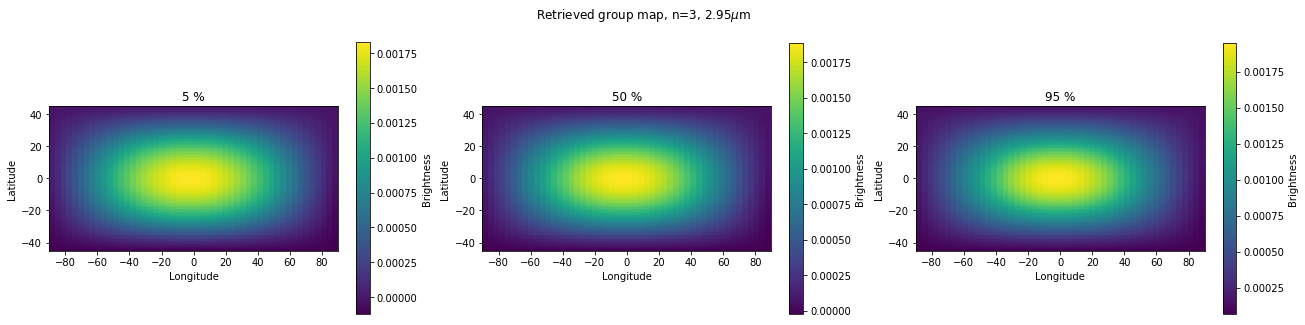

In [6]:
dataDir='data/sph_harmonic_coefficients_full_samples/'+model_name+'/'
waves=get_map_and_plot(waveInd=3,degree=3,dataDir=dataDir) #FINDME: using a different waveInd will show maps at a different wavelength; using a different degree will show a fit with a different number of spherical harmonics


## Use K means clustering to find Eigenspectra

In [4]:
def find_groups(dataDir,ngroups=4,degree=2,
               trySamples=45):
    """ 
    Find the eigenspectra using k means clustering
    
    Parameters
    ----------
    ngroups: int
        Number of eigenspectra to group results into
    degree: int
        Spherical harmonic degree to draw samples from
    testNum: int
        Test number (ie. lightcurve number 1,2, etc.)
    trySamples: int
        Number of samples to find groups with
        All samples take a long time so this takes a random
        subset of samples from which to draw posteriors
    """
    samplesDir = "data/sph_harmonic_coefficients_full_samples"
    #dataDir = "{}/eclipse_lightcurve_test{}/".format(samplesDir,testNum)
    tmp = np.load("{}spherearray_deg_{}.npz".format(dataDir,degree))
    outDictionary = tmp['arr_0'].tolist()
    samples = outDictionary['spherical coefficients'] # output from eigencurves

    eigenspectra_draws = []
    kgroup_draws = []

    randomIndices = np.random.randint(0,len(samples),trySamples)
    for draw in samples[randomIndices]:
        ## Re-formatting here into a legacy system
        ## 1st dimension is wavelength
        ## 2nd dimensions is data (0th element = wavelength)
        ##                        (1: elements are spherical harmonic coefficients)
        inputArr = np.zeros([10,samples.shape[1]+1])
        inputArr[:,0] = np.array([2.41,2.59,2.77,2.95,3.13,3.31,3.49,3.67,3.85,4.03])
        inputArr[:,1:] = draw.transpose()

        wavelengths, lats, lons, maps = eigenmaps.generate_maps(inputArr, N_lon=100, N_lat=100)

        kgroups = kmeans.kmeans(maps, ngroups)

        eigenspectra = bin_eigenspectra.bin_eigenspectra(maps, kgroups)

        eigenspectra_draws.append(eigenspectra)
        kgroup_draws.append(kgroups)
    return eigenspectra_draws, kgroup_draws

In [8]:
degree=3 #FINDME: change this to investigate fits with different numbers of spherical harmonics
eigenspectra_draws, kgroup_draws = find_groups(dataDir,degree=degree,trySamples=200,ngroups=3) #FINDME: change ngroups to cluster the data into a different number of eigengroups


## Plot the Eigenspectra

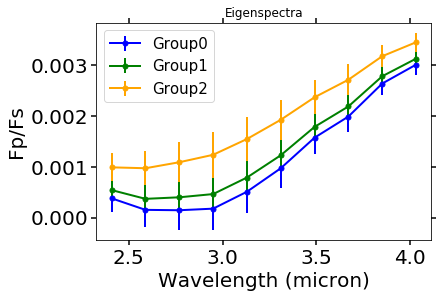

In [9]:
# THIS IS THE PART THAT NEEDS TO BE UPDATED FOR THE ERRORS THING
eigenspectra = np.mean(eigenspectra_draws, axis=0)
eigenerrs = np.std(eigenspectra_draws, axis=0)
kgroups = np.mean(kgroup_draws, axis=0)

counter=0
colors=['b','g','orange']
for spec, err in zip(eigenspectra, eigenerrs):
    p.errorbar(waves, spec, err,label=('Group'+np.str(counter)),linewidth=2,marker='.',markersize=10,color=colors[counter])
    counter+=1
p.xlabel('Wavelength (micron)',fontsize=20)
p.ylabel('Fp/Fs',fontsize=20)
plt.tick_params(labelsize=20,axis="both",right=True,top=True,width=1.5,length=5)
p.title('Eigenspectra')
p.legend(fontsize=15)
p.show()
#p.savefig('plots/eigenmap_and_spec/'+'hot_spot_spectra_deg3_3groups_error_bars.pdf',bbox_inches='tight')

## Plot Spatial Map of Eigengroups

In [ ]:
## Arthur's fancy maps go here

## Show original map and Eigenspectra

In [5]:
def show_orig_map(lam,spaxels,waveInd=0):#testNum=1):
    """
    Show the original map at a given wavelength
    
    Parameters
    -----------
    waveInd: int
        The wavelength index
    testNum: int
        The test Number (ie. lightcurve number)
    """
    #origData = np.load("data/maps/mystery_map{}.npz".format(testNum))
    lammin1 = 2.41; lammax1 = 3.98; dlam1 = 0.18
    #spaxels = origData["spaxels"]
    #lam = origData["wl"]
    lamlo, dlamlo = gen_lightcurves.construct_lam(lammin1, lammax1, dlam=dlam1)
    Nlamlo = len(lamlo)

    # Set HealPy pixel numbers
    Npix = spaxels.shape[0]

    # Define empty 2d array for spaxels
    spec2d = np.zeros((Npix, Nlamlo))

    # Loop over pixels filling with spectra
    for i in range(Npix):
        # Degrade the spectra to lower resolution
        spec2d[i,:] = gen_lightcurves.downbin_spec(spaxels[i, :], lam, lamlo, dlam = dlamlo)


    healpy.mollview(spec2d[:,waveInd], title=r"%0.2f $\mu$m" %lamlo[waveInd])
    p.show()
    return spec2d

/Users/megan/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


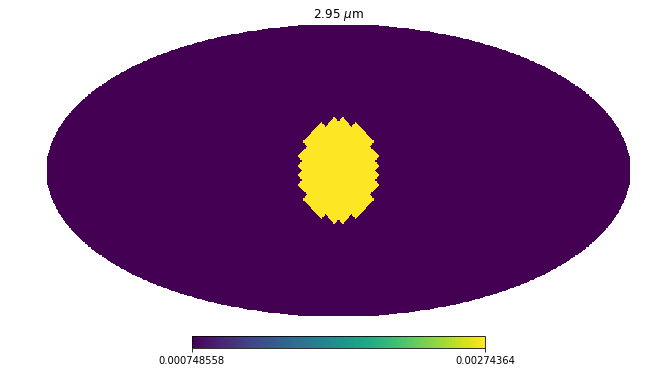

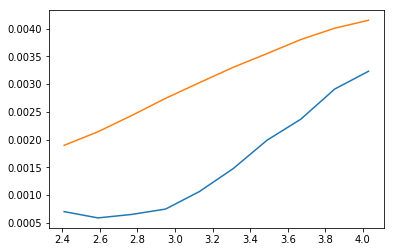

In [11]:
spec2D=show_orig_map(lamhr,spaxels,waveInd=3)
groupstarts=np.unique(spec2D[:,0])
p.figure()
for f in groupstarts:
    p.plot(waves,spec2D[spec2D[:,0]==f][0,:])
plt.show()

# A More Difficult Model

## Generate lightcurve using STARRY

In [7]:
model_name = 'secretmodel' #name of the model to perform the fit from

# Get the high-res wavelength grid and pixel spectra (spaxels)
lamhr, spaxels = gen_lightcurves.prep_map1()

# Generate the multi-wavelength eclipse lightcurves using starry
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, plot_lightcurves = False, plot_diagnostic = False)

# Save as a .npz file in data/input_lightcurves
filename='data/input_lightcurves/'+model_name+'.npz'
np.savez(filename,time=time,wl=lam,dwl=dlam,lightcurve=lcurves)

/Users/megan/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


## Fit eigencurves to lightcurve

In [ ]:
## Results are saved in data/sph_harmonic_coefficients_full_samples
for oneOrd in np.arange(2,6): #which degrees of spherical harmonics you want to create fits for
    run_higher_sph_harm.run_lc_noise_and_fit(norder=oneOrd,usePath=filename)

Found the previously-run file data/sph_harmonic_coefficients_full_samples/secretmodel/spherearray_deg_2.npz. Now exiting
Found the previously-run file data/sph_harmonic_coefficients_full_samples/secretmodel/spherearray_deg_3.npz. Now exiting
No previous run found, so running MCMC.
This can take a long time, especially for higher spherical harmonic orders
Fitting eigencurves now for order 4
Running MCMC at 2.41 um


/Users/megan/Documents/Megan School Work/ChicagoResearch/Conferences/Exoplanet Mapping October 2018/github master copy/eigenspectra/eigencurves.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  spheresbest[i] += fcoeffbest.T[j,2*i-1]-fcoeffbest.T[j,2*(i-1)]
/Users/megan/Documents/Megan School Work/ChicagoResearch/Conferences/Exoplanet Mapping October 2018/github master copy/eigenspectra/eigencurves.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  spheres[i] += fcoeff.T[j,2*i-1]-fcoeff.T[j,2*(i-1)]


Running MCMC at 2.5900000000000003 um
Running MCMC at 2.7700000000000005 um
Running MCMC at 2.9500000000000006 um
Running MCMC at 3.130000000000001 um
Running MCMC at 3.310000000000001 um
Running MCMC at 3.490000000000001 um
Running MCMC at 3.6700000000000013 um
Running MCMC at 3.8500000000000014 um
Running MCMC at 4.030000000000001 um
No previous run found, so running MCMC.
This can take a long time, especially for higher spherical harmonic orders
Fitting eigencurves now for order 5
Running MCMC at 2.41 um
Running MCMC at 2.5900000000000003 um
Running MCMC at 2.7700000000000005 um


## Display maps for median, 5th percentile, and 95th percentile from spherical harmonic fit

In [ ]:
dataDir='data/sph_harmonic_coefficients_full_samples/'+model_name+'/'
waves=get_map_and_plot(waveInd=3,degree=3,dataDir=dataDir) #FINDME: using a different waveInd will show maps at a different wavelength; using a different degree will show a fit with a different number of spherical harmonics


## Use K means clustering to find Eigenspectra

In [ ]:
degree=3 #FINDME: change this to investigate fits with different numbers of spherical harmonics
eigenspectra_draws, kgroup_draws = find_groups(dataDir,degree=degree,trySamples=200,ngroups=3) #FINDME: change ngroups to cluster the data into a different number of eigengroups


## Plot the Eigenspectra

In [ ]:
# THIS IS THE PART THAT NEEDS TO BE UPDATED FOR THE ERRORS THING
eigenspectra = np.mean(eigenspectra_draws, axis=0)
eigenerrs = np.std(eigenspectra_draws, axis=0)
kgroups = np.mean(kgroup_draws, axis=0)

counter=0
colors=['b','g','orange']
for spec, err in zip(eigenspectra, eigenerrs):
    p.errorbar(waves, spec, err,label=('Group'+np.str(counter)),linewidth=2,marker='.',markersize=10,color=colors[counter])
    counter+=1
p.xlabel('Wavelength (micron)',fontsize=20)
p.ylabel('Fp/Fs',fontsize=20)
plt.tick_params(labelsize=20,axis="both",right=True,top=True,width=1.5,length=5)
p.title('Eigenspectra')
p.legend(fontsize=15)
p.show()

## Plot Spatial Map of Eigengroups

In [ ]:
#Arthur's stuff here

## Show original map and Eigenspectra

In [ ]:
spec2D=show_orig_map(lamhr,spaxels,waveInd=3)
groupstarts=np.unique(spec2D[:,0])
p.figure()
for f in groupstarts:
    p.plot(waves,spec2D[spec2D[:,0]==f][0,:])
plt.show()

# Possible Sections to Keep/Remove

## Display Eigenspectra from posterior draws individually (instead of just the means)

Text(0, 0.5, 'F$_p$/F$_*$')

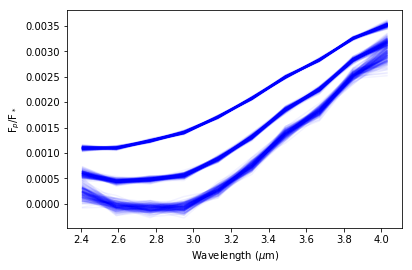

In [26]:
#Do we need this section or is it just for testing?
p.figure()
for oneSpec in np.array(eigenspectra_draws):
    for deg in np.arange(degree):
        p.plot(waves,oneSpec[deg,:],color='b',alpha=0.05)
p.xlabel('Wavelength ($\mu$m)')
p.ylabel('F$_p$/F$_*$')

### Show the posteriors for the retrieved maps

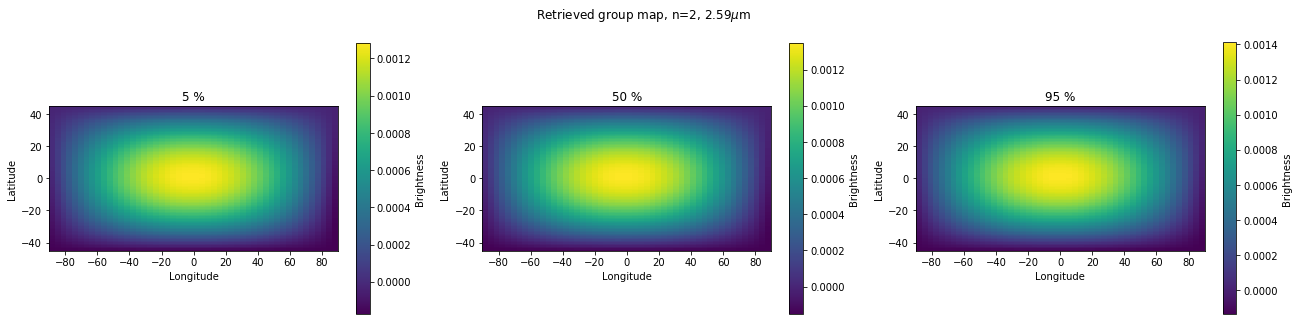

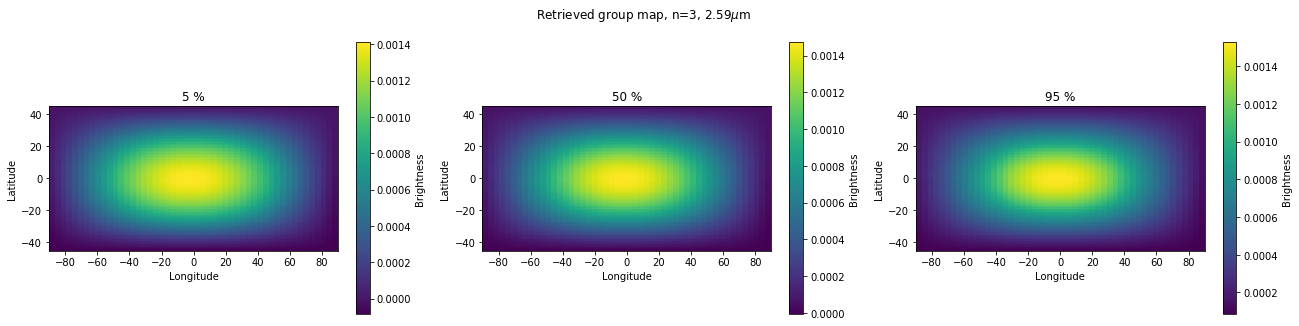

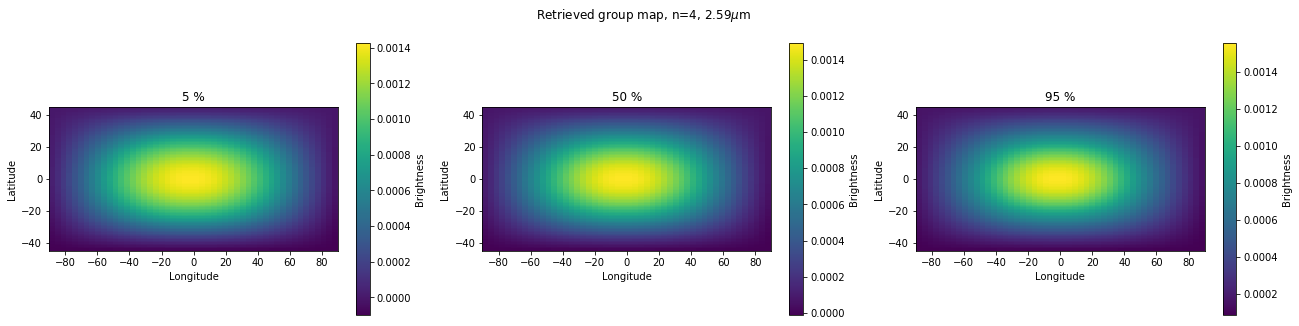

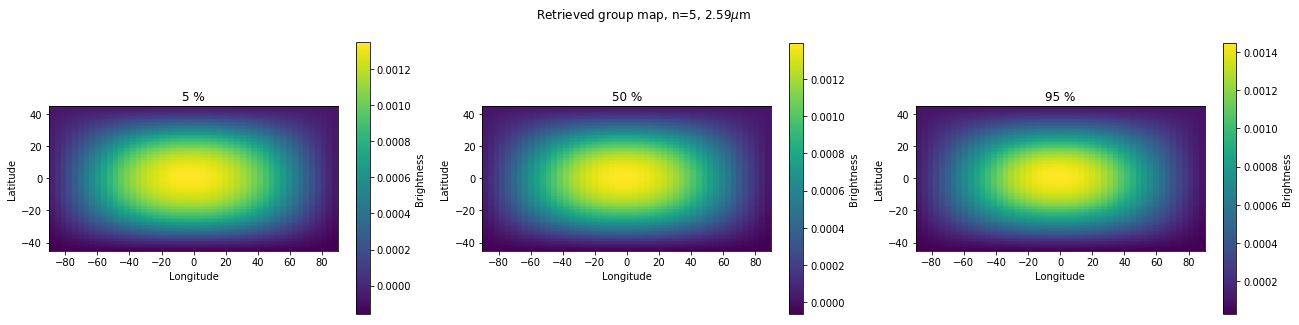

In [19]:
all_sph_degrees(waveInd=1)

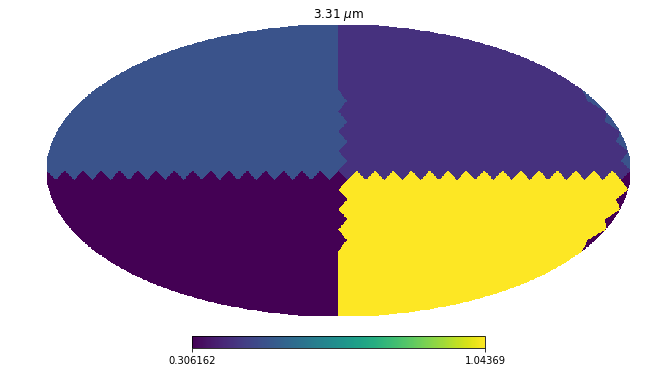

In [16]:
spec2D = show_orig_map(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/sph_harmonic_coefficients_full_samples/hotspot/spherearray_deg_6.npz'

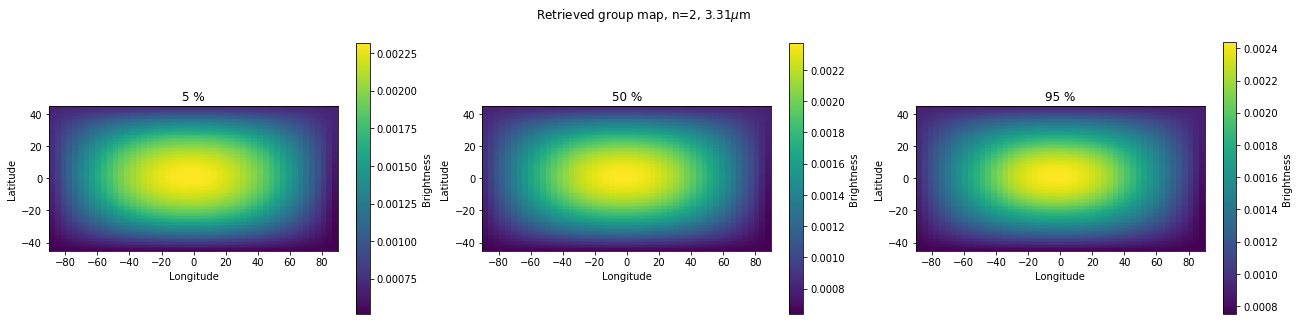

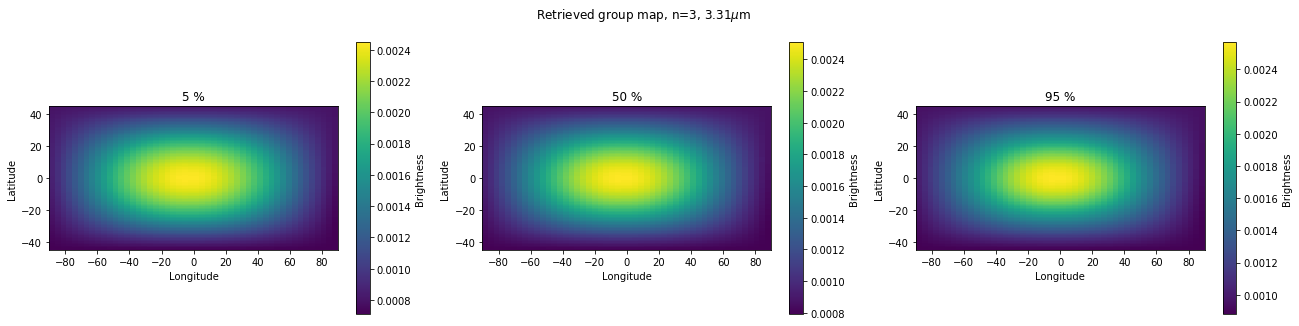

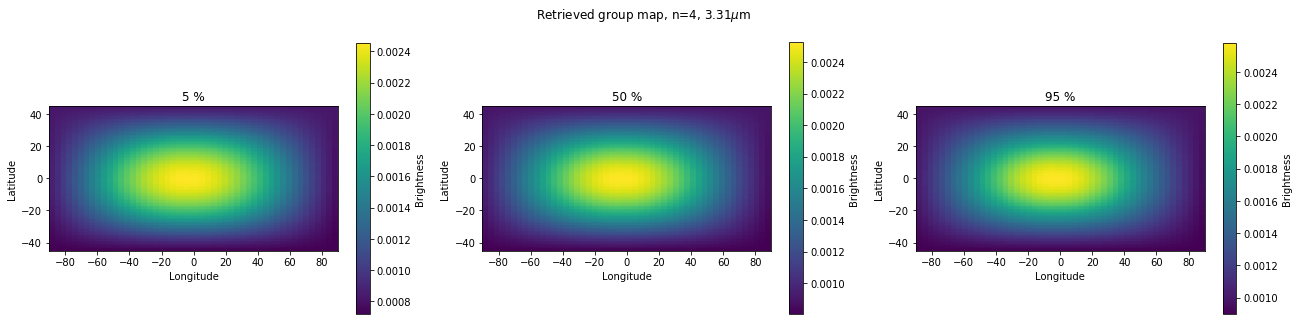

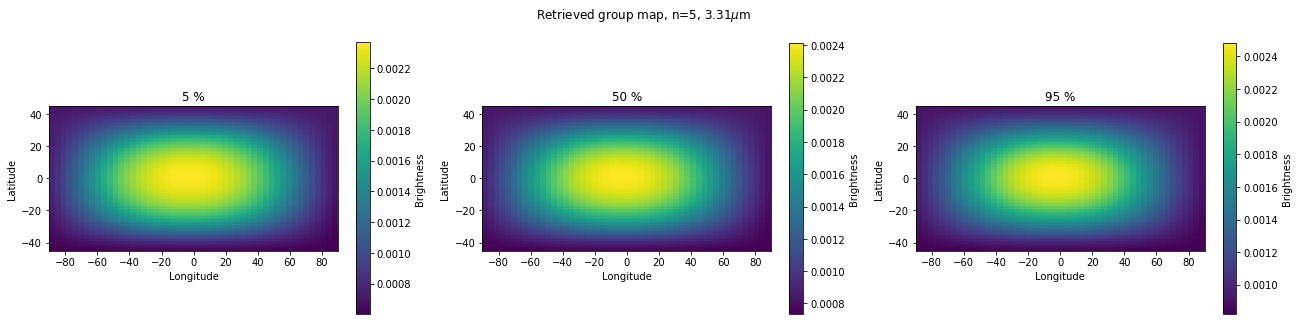

In [17]:
all_sph_degrees(5)

## Loop over many samples to get eigenmap and eigenspectra Errors

In [11]:
eigenspectra_draws, kgroup_draws = find_groups(degree=3,testNum=2)

NameError: name 'waves' is not defined

In [ ]:
eigenspectra = np.mean(eigenspectra_draws, axis=0)
eigenerrs = np.std(eigenspectra_draws, axis=0)
kgroups = np.mean(kgroup_draws, axis=0)

In [12]:
waves = outDictionary['wavelength (um)']
for spec, err in zip(eigenspectra, eigenerrs):
    p.errorbar(waves, spec, err)
p.xlabel('Wavelength (micron)')
p.ylabel('Fp/Fs')
p.title('Eigenspectra from light-curve fit')
p.show()

NameError: name 'outDictionary' is not defined

In [5]:
def show_eigenspec_and_map(ngroups=4,degree=5):
    """ Show the eigenspectra and map"""
    fig, (ax0, ax1) = p.subplots(1,2,figsize=(12,4))
    for ind,spec, err in zip(range(ngroups), eigenspectra, eigenerrs):
        ax0.errorbar(waves, spec, err, marker='o',
                  color=p.cm.viridis(float(ind)/float(ngroups-1)))
    ax0.set_xlabel('Wavelength (micron)')
    ax0.set_ylabel('Fp/Fs')
    ax0.set_title('Eigenspectra from light-curve fit, n={}'.format(degree))

    imData = ax1.imshow(kgroups)
    cbar = fig.colorbar(imData, ticks=np.arange(ngroups),ax=ax1)
    cbar.set_label('# Group')
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('Longitude')
    ax1.set_title('Retrieved group map')

In [15]:
show_eigenspec_and_map()

NameError: name 'eigenspectra' is not defined

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11291c378> (for post_execute):


TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

<Figure size 864x288 with 2 Axes>

## Show the original spectra and map

In [12]:
uniqueSpec, uniqueMap = np.unique(spec2d,axis=0,return_inverse=True)
nUniqueSpec = uniqueSpec.shape[0]
groupSpec2D = np.zeros(spec2d.shape[0])
fig, ax0 = p.subplots()
for ind,oneSpec in enumerate(uniqueSpec):
    color=p.cm.viridis(float(ind)/float(nUniqueSpec-1))
    ax0.plot(noiseDict['wavelength (um)'],oneSpec,color=color,label="Spec {}".format(ind))
ax0.legend()
ax0.set_xlabel('Wavelength ($\mu$m)')
ax0.set_ylabel('Relative Flux')
#fig.savefig('plots/original_maps/orig_quadrant_spec.pdf')
plotObj = healpy.mollview(uniqueMap,title='Spectral map',unit='Spectrum #')
#p.savefig('plots/original_maps/orig_quadrant_map.pdf')

NameError: name 'spec2d' is not defined